<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_DBA_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Driver Behaviour Analysis Sub Model for MSFCD and DDFAD**

## **Setup & Data Loading**

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

#set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

#upload dataset
from google.colab import files
uploaded = files.upload()

#load data
df = pd.read_csv('sensor_raw.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Columns: {df.columns.tolist()}")

Saving sensor_raw.csv to sensor_raw (19).csv
Dataset loaded: 1114 rows, 7 columns
Columns: ['Target(Class)', 'GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']


## **Data Inspection**

In [187]:
print("DATA INSPECTION")

#load and inspect
df = pd.read_csv('sensor_raw.csv')

print("\n1. Dataset shape:")
print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n2. Column names:")
print(df.columns.tolist())

print("\n3. First 20 rows:")
print(df.head(20))

print("\n4. Last 20 rows:")
print(df.tail(20))

print("\n5. Data types:")
print(df.dtypes)

print("\n6. Unique values in each column:")
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"   {col}: {unique_vals} unique values")
    if unique_vals < 20:  #if few unique values are there, show them
        print(f"      Values: {sorted(df[col].unique())}")

print("\n7. Statistical summary:")
print(df.describe())

print("\n8. Check if there's a label/class column:")
for col in df.columns:
    if df[col].dtype in ['int64', 'object']:
        print(f"\n   Column '{col}' might be labels:")
        print(f"   Unique values: {sorted(df[col].unique())}")
        print(f"   Value counts:\n{df[col].value_counts()}")

DATA INSPECTION

1. Dataset shape:
   Rows: 1114, Columns: 7

2. Column names:
['Target(Class)', 'GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']

3. First 20 rows:
    Target(Class)     GyroX     GyroY     GyroZ      AccX      AccY      AccZ
0               1 -0.923664  3.694656  0.824427  0.162598 -0.086670 -0.969482
1               1 -0.908397  4.534351  0.832061  0.175781 -0.100586 -1.013184
2               1  0.786260  3.969466  0.587786  0.322754 -0.140381 -0.911621
3               1  0.335878  4.564885 -0.251908  0.480225 -0.226807 -0.936768
4               1  3.351145  2.694656 -0.106870  0.426025 -0.253906 -0.950195
5               1 -1.503817  3.183206 -1.656489  0.383789 -0.141602 -0.919678
6               1  1.358779  8.725191 -0.946565  0.404785 -0.257324 -0.862549
7               1 -1.083969  4.106870 -0.625954  0.346924 -0.106201 -0.969971
8               1  0.053435  5.083969 -2.221374  0.276611 -0.257568 -1.008301
9               1 -1.106870  3.656489  0.778626  0.15

## **Exploratory Data Analysis (EDA)**

EXPLORATORY DATA ANALYSIS

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Target(Class)  1114 non-null   int64  
 1   GyroX          1114 non-null   float64
 2   GyroY          1114 non-null   float64
 3   GyroZ          1114 non-null   float64
 4   AccX           1114 non-null   float64
 5   AccY           1114 non-null   float64
 6   AccZ           1114 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 61.1 KB

2. First 10 rows:
   Target(Class)     GyroX     GyroY     GyroZ      AccX      AccY      AccZ
0              1 -0.923664  3.694656  0.824427  0.162598 -0.086670 -0.969482
1              1 -0.908397  4.534351  0.832061  0.175781 -0.100586 -1.013184
2              1  0.786260  3.969466  0.587786  0.322754 -0.140381 -0.911621
3              1  0.335878  4.564885 -0.251908  0.480225 -0.226807 -0.936768

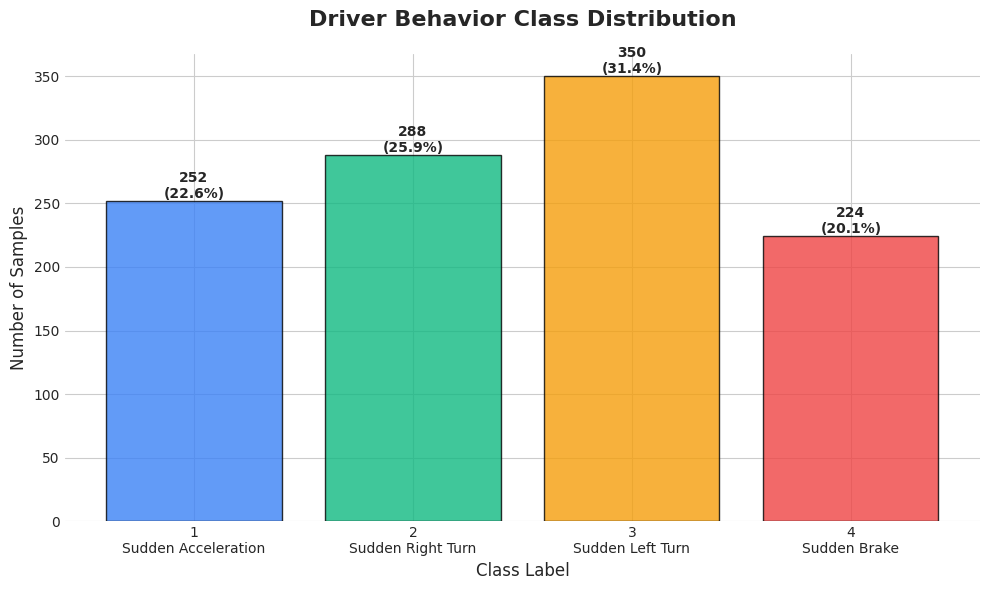


5. Sensor Statistics:
             GyroX        GyroY        GyroZ         AccX         AccY  \
count  1114.000000  1114.000000  1114.000000  1114.000000  1114.000000   
mean     -0.829957     4.122309     1.076404     0.252417    -0.095110   
std       3.404297     3.252790    12.049384     0.183155     0.190407   
min     -14.946565   -10.351145   -50.259542    -0.252686    -0.793457   
25%      -2.274809     2.610687     0.282443     0.132202    -0.179077   
50%      -0.698473     4.290076     0.961832     0.244507    -0.102295   
75%       0.784351     5.761450     1.992366     0.372559    -0.023010   
max      12.778626    16.793893    45.442748     0.747803     0.768555   

              AccZ  
count  1114.000000  
mean     -0.983215  
std       0.098061  
min      -1.367920  
25%      -1.031372  
50%      -0.986938  
75%      -0.928223  
max      -0.456787  


In [189]:
print("EXPLORATORY DATA ANALYSIS")

#dataset info
print("\n1. Dataset Info:")
df.info()

print("\n2. First 10 rows:")
print(df.head(10))

print("\n3. Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

print("\n4. Class Distribution:")
class_counts = df['Target(Class)'].value_counts().sort_index()
print(class_counts)
print(f"\nTotal samples: {len(df)}")

#class labels mapping
class_labels = {
    1: 'Sudden Acceleration',
    2: 'Sudden Right Turn',
    3: 'Sudden Left Turn',
    4: 'Sudden Brake'
}

#visualize class distribution
plt.figure(figsize=(10, 6))
colors = ['#3b82f6', '#10b981', '#f59e0b', '#ef4444']
bars = plt.bar(class_counts.index, class_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Driver Behavior Class Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(class_counts.index,
           [f"{i}\n{class_labels[i]}" for i in class_counts.index],
           fontsize=10)

#add value labels on bars
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

#sensor statistics
print("\n5. Sensor Statistics:")
sensor_cols = ['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']
print(df[sensor_cols].describe())

## **Sensor data visualization**

SENSOR DATA VISUALIZATION


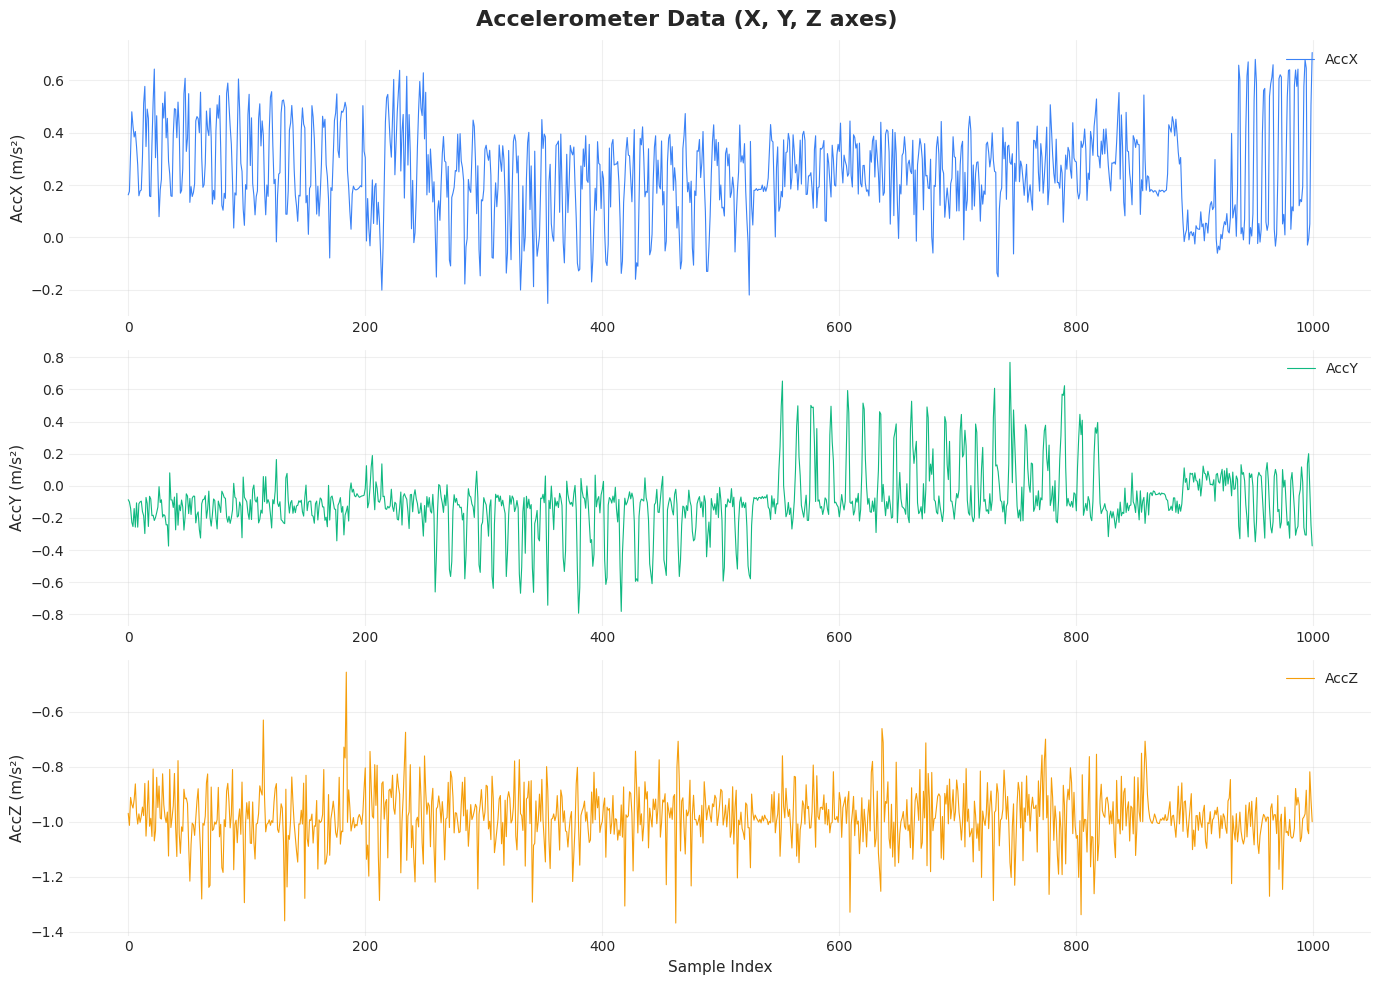

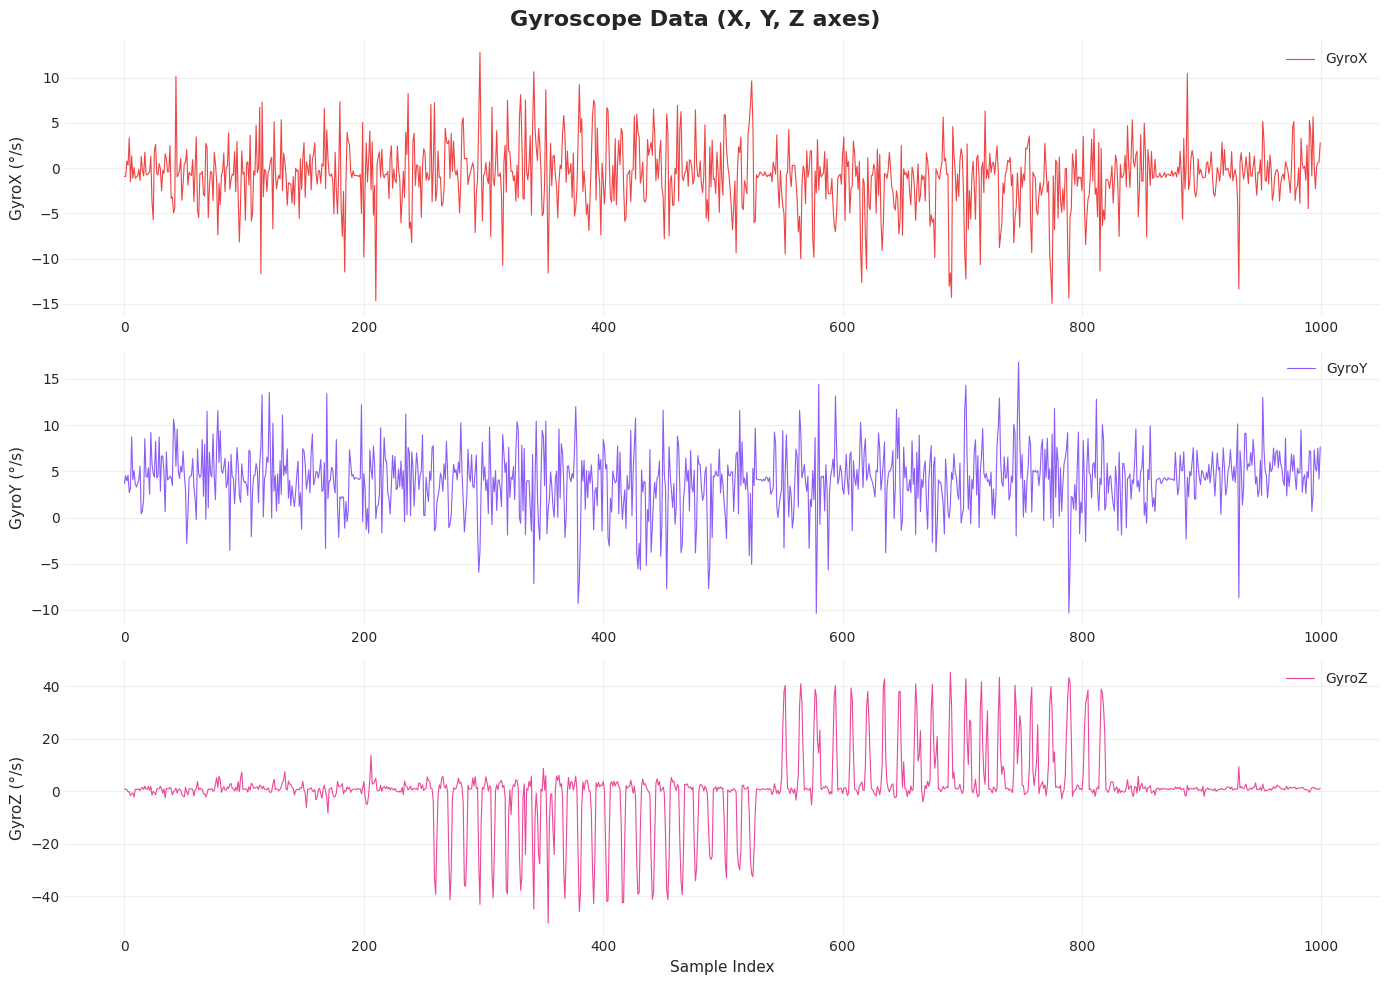

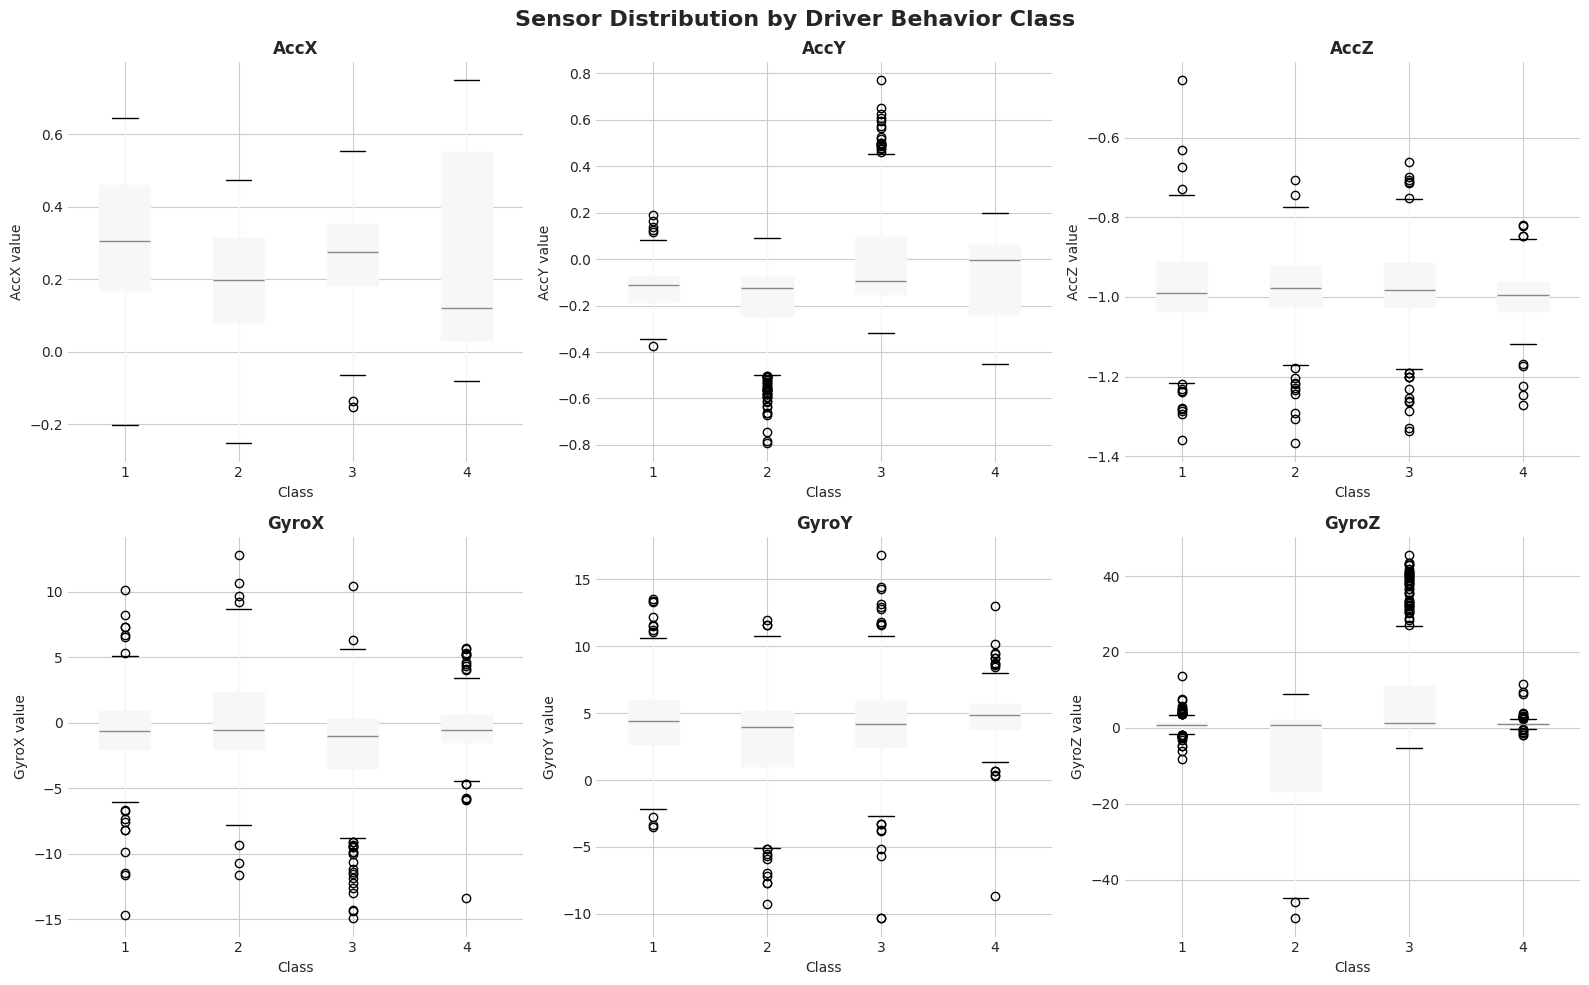

In [191]:
print("SENSOR DATA VISUALIZATION")

#accelerometer data
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Accelerometer Data (X, Y, Z axes)', fontsize=16, fontweight='bold')

sample_size = min(1000, len(df))
sample_df = df.head(sample_size)

axes[0].plot(sample_df['AccX'], label='AccX', color='#3b82f6', linewidth=0.8)
axes[0].set_ylabel('AccX (m/s²)', fontsize=11)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sample_df['AccY'], label='AccY', color='#10b981', linewidth=0.8)
axes[1].set_ylabel('AccY (m/s²)', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

axes[2].plot(sample_df['AccZ'], label='AccZ', color='#f59e0b', linewidth=0.8)
axes[2].set_ylabel('AccZ (m/s²)', fontsize=11)
axes[2].set_xlabel('Sample Index', fontsize=11)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#gyroscope data
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Gyroscope Data (X, Y, Z axes)', fontsize=16, fontweight='bold')

axes[0].plot(sample_df['GyroX'], label='GyroX', color='#ef4444', linewidth=0.8)
axes[0].set_ylabel('GyroX (°/s)', fontsize=11)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sample_df['GyroY'], label='GyroY', color='#8b5cf6', linewidth=0.8)
axes[1].set_ylabel('GyroY (°/s)', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

axes[2].plot(sample_df['GyroZ'], label='GyroZ', color='#ec4899', linewidth=0.8)
axes[2].set_ylabel('GyroZ (°/s)', fontsize=11)
axes[2].set_xlabel('Sample Index', fontsize=11)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#box plot by class
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Sensor Distribution by Driver Behavior Class', fontsize=16, fontweight='bold')

sensor_names = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
for idx, sensor in enumerate(sensor_names):
    row = idx // 3
    col = idx % 3
    df.boxplot(column=sensor, by='Target(Class)', ax=axes[row, col], patch_artist=True)
    axes[row, col].set_title(f'{sensor}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Class', fontsize=10)
    axes[row, col].set_ylabel(f'{sensor} value', fontsize=10)

plt.suptitle('Sensor Distribution by Driver Behavior Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [192]:
print("DATA PREPROCESSING")

df_clean = df.copy()

print(f"\n1. Dataset shape: {df_clean.shape}")

#check for missing values
print("\n2. Checking for missing values...")
missing_before = df_clean.isnull().sum().sum()
print(f"Missing values: {missing_before}")

if missing_before > 0:
    df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
    print(f"Missing values after filling: {df_clean.isnull().sum().sum()}")

#separate features and target
print("\n3. Separating features and target...")
X = df_clean[['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']]
y = df_clean['Target(Class)']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {X.columns.tolist()}")

#check for duplicates
duplicates = df_clean.duplicated().sum()
print(f"\n4. Duplicate rows: {duplicates}")
if duplicates > 0:
    print("Removing duplicates...")
    df_clean = df_clean.drop_duplicates()
    X = df_clean[['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']]
    y = df_clean['Target(Class)']
    print(f"New shape after removing duplicates: {X.shape}")

DATA PREPROCESSING

1. Dataset shape: (1114, 7)

2. Checking for missing values...
Missing values: 0

3. Separating features and target...
Feature matrix shape: (1114, 6)
Target vector shape: (1114,)
Features: ['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']

4. Duplicate rows: 0


## **Feature Engineering**

In [195]:
print("FEATURE ENGINEERING 2")

#add to existing engineered features
X_advanced = X_engineered.copy()

#statistical features (rolling windows)
print("\n1. Adding rolling window statistics (simulating time series)...")
window_size = 3  #3 samples ≈ 1.5 seconds at 2Hz

for sensor in ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']:
    #rolling mean (smooth signal)
    X_advanced[f'{sensor}_rolling_mean'] = X_advanced[sensor].rolling(window=window_size, min_periods=1).mean()

    #rolling std (detect sudden changes)
    X_advanced[f'{sensor}_rolling_std'] = X_advanced[sensor].rolling(window=window_size, min_periods=1).std().fillna(0)

    #rolling max to min (range of motion)
    X_advanced[f'{sensor}_rolling_range'] = (
        X_advanced[sensor].rolling(window=window_size, min_periods=1).max() -
        X_advanced[sensor].rolling(window=window_size, min_periods=1).min()
    ).fillna(0)

#energy based features
print("2. Adding energy and power features...")
X_advanced['accel_energy'] = (
    X_advanced['AccX']**2 + X_advanced['AccY']**2 + X_advanced['AccZ']**2
)
X_advanced['gyro_energy'] = (
    X_advanced['GyroX']**2 + X_advanced['GyroY']**2 + X_advanced['GyroZ']**2
)

#spectral features (frequency domain indicators)
print("3. Adding spectral indicators...")
X_advanced['accel_spectral_power'] = np.abs(X_advanced['accel_magnitude'].diff()).fillna(0)
X_advanced['gyro_spectral_power'] = np.abs(X_advanced['gyro_magnitude'].diff()).fillna(0)

#angle and orientation features
print("4. Adding orientation features...")
X_advanced['pitch'] = np.arctan2(X_advanced['AccY'],
                                  np.sqrt(X_advanced['AccX']**2 + X_advanced['AccZ']**2))
X_advanced['roll'] = np.arctan2(X_advanced['AccX'], X_advanced['AccZ'])

#cross axis interactions
print("5. Adding cross-axis interactions...")
X_advanced['acc_gyro_xy_interaction'] = X_advanced['AccX'] * X_advanced['GyroY']
X_advanced['acc_gyro_xz_interaction'] = X_advanced['AccX'] * X_advanced['GyroZ']

print(f"\n Total features: {X_advanced.shape[1]}")
print(f"   Original: {X.shape[1]}")
print(f"   Engineered: {X_advanced.shape[1] - X.shape[1]}")

X_engineered = X_advanced

FEATURE ENGINEERING 2

1. Adding rolling window statistics (simulating time series)...
2. Adding energy and power features...
3. Adding spectral indicators...
4. Adding orientation features...
5. Adding cross-axis interactions...

 Total features: 45
   Original: 6
   Engineered: 39


## **Handle Class Imbalance**

CLASS BALANCING 2

Before balancing:
Target(Class)
1    252
2    288
3    350
4    224
Name: count, dtype: int64

Imbalance ratio: 1.56

Applying SMOTE with BorderlineSMOTE strategy...

After BorderlineSMOTE balancing:
Target(Class)
1    350
2    350
3    350
4    350
Name: count, dtype: int64
New shape: (1400, 45)


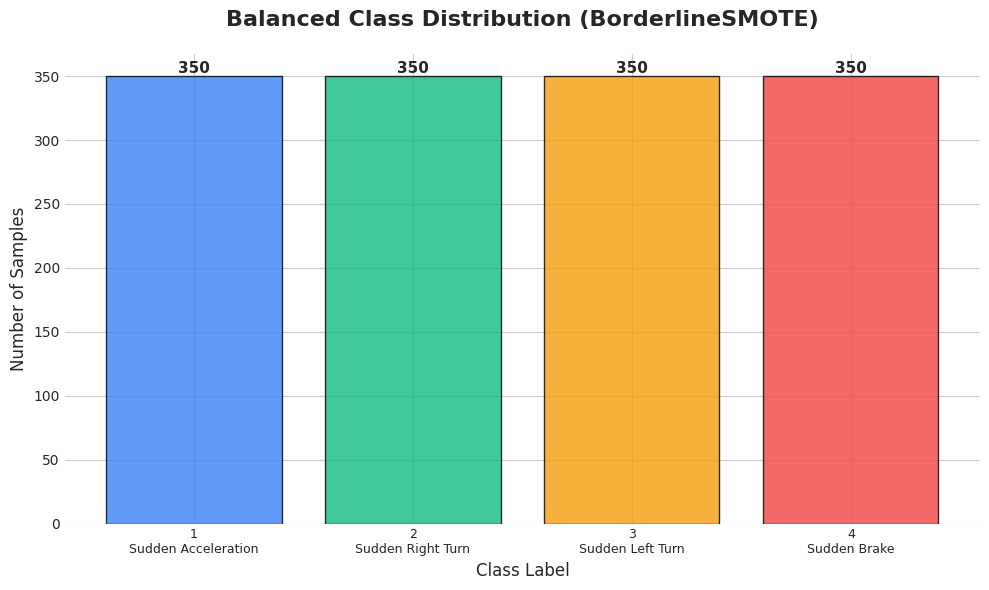

In [196]:
print("CLASS BALANCING 2")

print(f"\nBefore balancing:")
print(y.value_counts().sort_index())

class_counts = y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("\nApplying SMOTE with BorderlineSMOTE strategy...")
    from imblearn.over_sampling import BorderlineSMOTE

    #borderline SMOTE focuses on boundary cases (harder to classify)
    smote = BorderlineSMOTE(random_state=42, k_neighbors=3, kind='borderline-1')
    X_balanced, y_balanced = smote.fit_resample(X_engineered, y)

    print(f"\nAfter BorderlineSMOTE balancing:")
    balanced_counts = pd.Series(y_balanced).value_counts().sort_index()
    print(balanced_counts)
    print(f"New shape: {X_balanced.shape}")
else:
    X_balanced = X_engineered
    y_balanced = y

#visualize
plt.figure(figsize=(10, 6))
balanced_counts = pd.Series(y_balanced).value_counts().sort_index()
colors = ['#3b82f6', '#10b981', '#f59e0b', '#ef4444']
bars = plt.bar(balanced_counts.index, balanced_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Balanced Class Distribution (BorderlineSMOTE)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(balanced_counts.index,
           [f"{i}\n{class_labels[i]}" for i in balanced_counts.index],
           fontsize=9)
for bar, count in zip(bars, balanced_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{count}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()

##**Train Test Split**


In [197]:
print("FEATURE SCALING & DATA SPLITTING")

#convert class labels from 1-4 to 0-3 (XGBoost requirement)
y_balanced_adjusted = y_balanced - 1  # Subtract 1 to convert to 0-indexed

#verify conversion
print(f"Original classes: {sorted(y_balanced.unique())}")
print(f"Adjusted classes: {sorted(y_balanced_adjusted.unique())}")

#split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced_adjusted,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced_adjusted
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

#feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"\nFeatures scaled using StandardScaler")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

#check distribution
print("\nTrain set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

FEATURE SCALING & DATA SPLITTING
Original classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Adjusted classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Train set: 1120 samples
Test set: 280 samples

Features scaled using StandardScaler
Training set shape: (1120, 45)
Test set shape: (280, 45)

Train set class distribution:
Target(Class)
0    280
1    280
2    280
3    280
Name: count, dtype: int64

Test set class distribution:
Target(Class)
0    70
1    70
2    70
3    70
Name: count, dtype: int64


## **Model Training**

In [200]:
print("TRAINING XGBOOST MODEL WITH OPTIMIZED PARAMETERS 2")


print(f"\nXGBoost Version: {xgb.__version__}")

#optimized XGBoost for small dataset
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0,
    reg_alpha=0.01,
    reg_lambda=0.5,
    min_child_weight=1,
    scale_pos_weight=1,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    objective='multi:softmax',
    num_class=4,
    tree_method='hist',
    early_stopping_rounds=50
)

print("\nModel Configuration:")
print("\nTraining in progress...")

#train with early stopping
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=50
)

print(f"\nBest iteration: {model.best_iteration}")
print("\nTRAINING COMPLETE!")

TRAINING XGBOOST MODEL WITH OPTIMIZED PARAMETERS 2

XGBoost Version: 3.1.3

Model Configuration:

Training in progress...
[0]	validation_0-mlogloss:1.31234	validation_1-mlogloss:1.32683
[50]	validation_0-mlogloss:0.20941	validation_1-mlogloss:0.50583
[100]	validation_0-mlogloss:0.06158	validation_1-mlogloss:0.41514
[150]	validation_0-mlogloss:0.02715	validation_1-mlogloss:0.40192
[190]	validation_0-mlogloss:0.01768	validation_1-mlogloss:0.40258

Best iteration: 140

TRAINING COMPLETE!


## **Model Evaluation**

In [202]:
print("MODEL EVALUATION")

#make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)

#calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nPERFORMANCE METRICS:")
print(f"Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"F1-Score (Macro):    {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")

#for display, convert predictions back to original labels (1-4)
y_test_original = y_test + 1
y_pred_test_original = y_pred_test + 1

#detailed classification report
print("\nCLASSIFICATION REPORT:")
class_names = [class_labels[i] for i in sorted(class_labels.keys())]
print(classification_report(y_test_original, y_pred_test_original, target_names=class_names, labels=[1,2,3,4]))

#class accuracy
print("\nPER CLASS ACCURACY:")
cm = confusion_matrix(y_test_original, y_pred_test_original, labels=[1,2,3,4])
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"Class {i+1} ({class_name:22s}): {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

MODEL EVALUATION

PERFORMANCE METRICS:
Train Accuracy: 1.0000 (100.00%)
Test Accuracy:  0.8714 (87.14%)
F1-Score (Macro):    0.8719
F1-Score (Weighted): 0.8719

CLASSIFICATION REPORT:
                     precision    recall  f1-score   support

Sudden Acceleration       0.90      0.86      0.88        70
  Sudden Right Turn       0.81      0.91      0.86        70
   Sudden Left Turn       0.84      0.81      0.83        70
       Sudden Brake       0.95      0.90      0.93        70

           accuracy                           0.87       280
          macro avg       0.87      0.87      0.87       280
       weighted avg       0.87      0.87      0.87       280


PER CLASS ACCURACY:
Class 1 (Sudden Acceleration   ): 0.8571 (85.71%)
Class 2 (Sudden Right Turn     ): 0.9143 (91.43%)
Class 3 (Sudden Left Turn      ): 0.8143 (81.43%)
Class 4 (Sudden Brake          ): 0.9000 (90.00%)


## **Confusion Matrix**

CONFUSION MATRIX


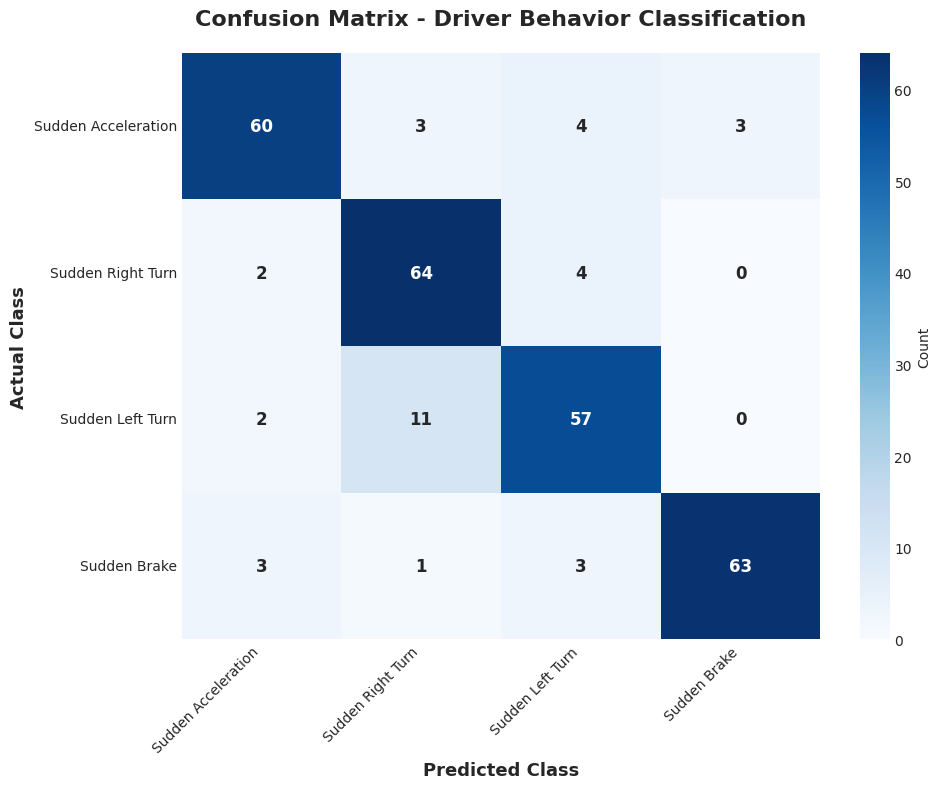

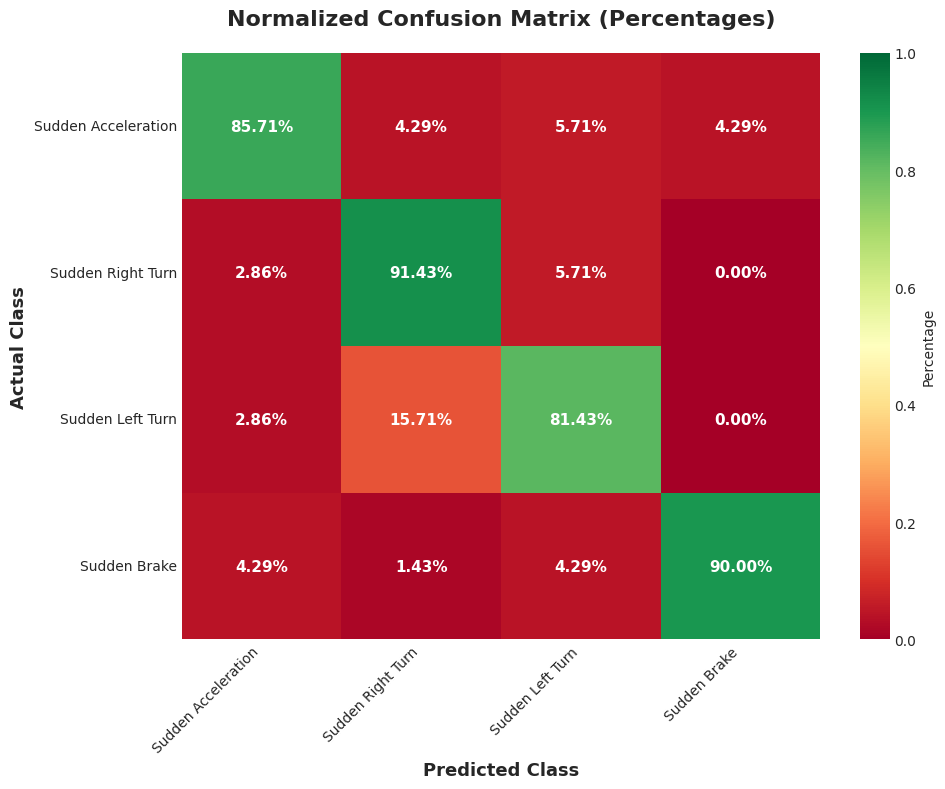

In [203]:
print("CONFUSION MATRIX")

#convert predictions back to original labels for visualization
y_test_original = y_test + 1
y_pred_test_original = y_pred_test + 1

#compute confusion matrix with original labels
cm = confusion_matrix(y_test_original, y_pred_test_original, labels=[1,2,3,4])

#confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Confusion Matrix - Driver Behavior Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage'},
            annot_kws={'size': 11, 'weight': 'bold'},
            vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Percentages)',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Feature Importance Analysis**

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
            feature  importance
 GyroZ_rolling_mean    0.083549
  AccX_rolling_mean    0.053537
GyroZ_rolling_range    0.048161
  AccY_rolling_mean    0.043516
   AccX_rolling_std    0.042946
  GyroZ_rolling_std    0.040343
               roll    0.039574
   AccY_rolling_std    0.038049
              GyroZ    0.036527
 AccY_rolling_range    0.035862
 AccX_rolling_range    0.029984
 AccZ_rolling_range    0.027265
        gyro_energy    0.023891
               AccY    0.022335
              pitch    0.019685


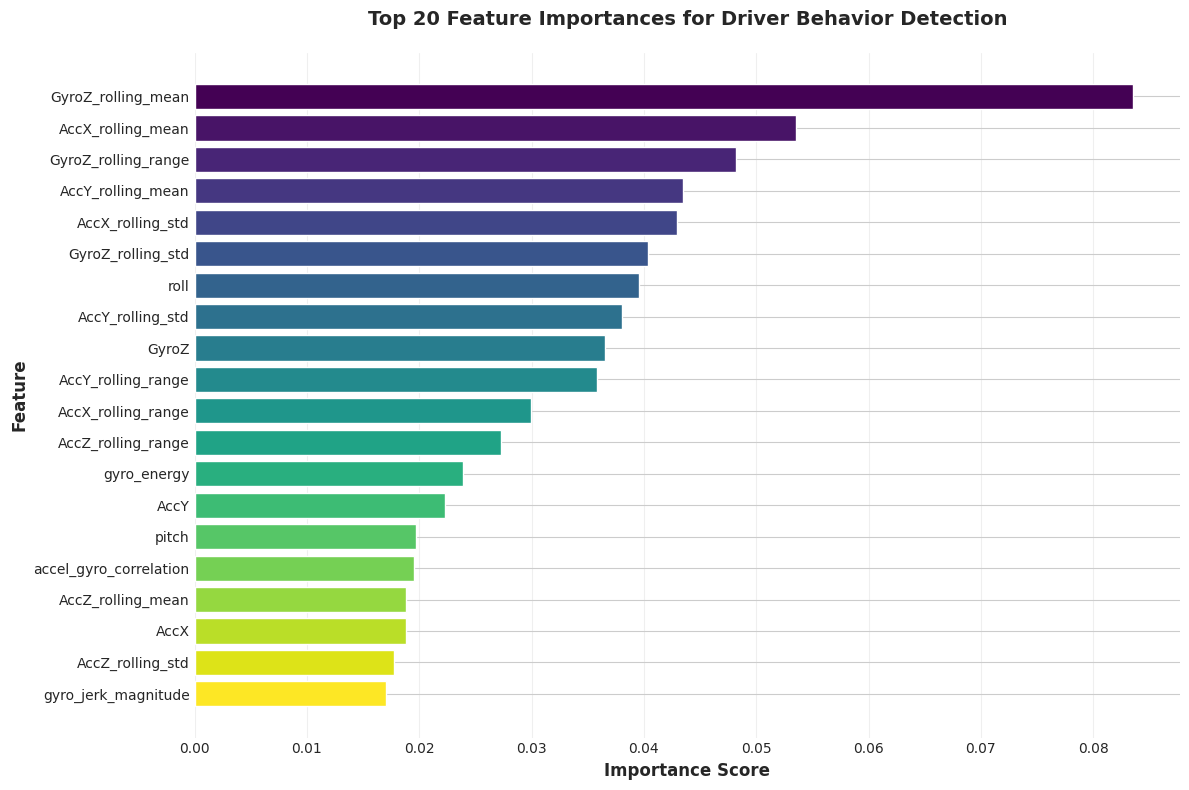

In [206]:
print("FEATURE IMPORTANCE ANALYSIS")

#get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

#visualize features
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance))
top_features = feature_importance.head(top_n)
colors_grad = plt.cm.viridis(np.linspace(0, 1, top_n))
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors_grad)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances for Driver Behavior Detection',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## **Model Export for Deployment**

In [207]:
print("EXPORTING MODEL FOR ANDROID")

#model filename
MODEL_FILENAME = "TransitLK_MSFCD_DDFAD_DBA_XGB.pkl"
SCALER_FILENAME = "TransitLK_MSFCD_DDFAD_DBA_XGB_Scaler.pkl"

# Save the trained model
joblib.dump(model, MODEL_FILENAME)
print(f"Model saved: {MODEL_FILENAME}")

# Save the scaler
joblib.dump(scaler, SCALER_FILENAME)
print(f"Scaler saved: {SCALER_FILENAME}")

# Create metadata
metadata = {
    'model_name': 'TransitLK Driver Behavior Analysis Model',
    'model_type': 'XGBoost Multi Class Classifier',
    'classes': class_labels,
    'class_mapping_note': 'Model uses 0-indexed classes [0,1,2,3]. Add 1 to get original labels [1,2,3,4]',
    'num_classes': len(class_labels),
    'features': X_train_scaled.columns.tolist(),
    'num_features': len(X_train_scaled.columns),
    'test_accuracy': float(test_accuracy),
    'f1_score_macro': float(test_f1_macro),
    'f1_score_weighted': float(test_f1_weighted),
    'train_samples': int(len(X_train)),
    'test_samples': int(len(X_test)),
    'sampling_rate': '2 samples/second',
    'window_size': '14 seconds (28 samples recommended)',
    'sensor': 'MPU6050 (or phone accelerometer + gyroscope)',
    'vehicle_type': 'Bus',
    'xgboost_version': xgb.__version__,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

#save metadata
import json
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved: model_metadata.json")

print("\n" + "="*60)
print("ANDROID INTEGRATION GUIDE")
print("="*60)
print("\nFEATURE ORDER (MUST MATCH IN ANDROID):")
print("-" * 60)
for i, feat in enumerate(X_train_scaled.columns, 1):
    print(f"  {i:2d}. {feat}")

print("\nCLASS LABELS FOR ANDROID:")
print("-" * 60)
print("IMPORTANT: Model outputs 0-3, add 1 to get original labels!")
print("-" * 60)
print("Model Output → Original Label → Behavior")
for model_class in range(4):
    original_class = model_class + 1
    print(f"     {model_class}       →       {original_class}       → {class_labels[original_class]}")

print("\nPREPROCESSING STEPS FOR ANDROID:")
print("-" * 60)
print("  1. Collect sensor data at ~2 samples/second")
print("  2. Use 14-second window (28 samples)")
print("  3. Extract features in the EXACT order shown above")
print("  4. Apply StandardScaler using saved scaler")
print("  5. Pass to XGBoost model")
print("  6. Get prediction (0-3) and ADD 1 to get behavior class (1-4)")
print("  7. Map to behavior: 1=Acceleration, 2=Right, 3=Left, 4=Brake")

print("\nMODEL PERFORMANCE:")
print("-" * 60)
print(f"  Overall Accuracy: {test_accuracy*100:.2f}%")
print(f"  F1-Score (Macro): {test_f1_macro:.4f}")

print("\nALL FILES READY FOR DEPLOYMENT!")
print("="*60)

#download files
files.download(MODEL_FILENAME)
files.download(SCALER_FILENAME)
files.download('model_metadata.json')

EXPORTING MODEL FOR ANDROID
Model saved: TransitLK_MSFCD_DDFAD_DBA_XGB.pkl
Scaler saved: TransitLK_MSFCD_DDFAD_DBA_XGB_Scaler.pkl
Metadata saved: model_metadata.json

ANDROID INTEGRATION GUIDE

FEATURE ORDER (MUST MATCH IN ANDROID):
------------------------------------------------------------
   1. GyroX
   2. GyroY
   3. GyroZ
   4. AccX
   5. AccY
   6. AccZ
   7. accel_magnitude
   8. gyro_magnitude
   9. accel_jerk_x
  10. accel_jerk_y
  11. accel_jerk_z
  12. gyro_jerk_x
  13. gyro_jerk_y
  14. gyro_jerk_z
  15. accel_jerk_magnitude
  16. gyro_jerk_magnitude
  17. accx_accy_ratio
  18. gyrox_gyroy_ratio
  19. accel_gyro_correlation
  20. AccX_rolling_mean
  21. AccX_rolling_std
  22. AccX_rolling_range
  23. AccY_rolling_mean
  24. AccY_rolling_std
  25. AccY_rolling_range
  26. AccZ_rolling_mean
  27. AccZ_rolling_std
  28. AccZ_rolling_range
  29. GyroX_rolling_mean
  30. GyroX_rolling_std
  31. GyroX_rolling_range
  32. GyroY_rolling_mean
  33. GyroY_rolling_std
  34. GyroY_rol

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>